## Семинар 6 "Transfer Learning"

ФИО: __Федотова Алёна Дмитриевна__

## Задание

Предлагается поучаствовать в конкурсе https://www.kaggle.com/c/human-protein-atlas-image-classification 

Для зачета требуется получить значение f-меры на leaderboard не меньше 0.25 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте команду или своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 5, 3, 1 балл соответственно. (deadline: 23:59 19 ноября 2018). Скорее всего будут дополнительные плюшки для призеров конкурса.

При работе на сервере используйте данные из папки /mnt/disk/exch/human-protein-atlas-image-classification . 

### У kaggle есть удобное api

In [ ]:
!pip install kaggle # use --user when working on server
## replace ~/.kaggle/kaggle.json with a file from your kaggle profile page
## Download data
!kaggle competitions download -c human-protein-atlas-image-classification
## Sumbit 
!kaggle competitions submit -c human-protein-atlas-image-classification -f submit.csv -m "submition description"

In [46]:
%matplotlib inline
import sys, os 
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.nn import CrossEntropyLoss, Sequential, Linear, Sigmoid, Tanh, BCELoss, Softmax, BatchNorm1d
from torch.utils.data.sampler import Sampler, SubsetRandomSampler, WeightedRandomSampler
from PIL import Image # Replace by accimage when ready
from PIL.Image import FLIP_LEFT_RIGHT, FLIP_TOP_BOTTOM, ROTATE_90, ROTATE_180, ROTATE_270
from PIL.ImageEnhance import Color, Contrast, Brightness, Sharpness
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [47]:
csv_ = pd.read_csv("/mnt/disk/exch/human-protein-atlas-image-classification/train.csv")

In [48]:
csv_.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [49]:
class SubsetSampler(Sampler):
     """Samples elements from a given list of indices.
 
     Arguments:
         indices (list): a list of indices
     """
 
     def __init__(self, indices):
        self.num_samples = len(indices)
        self.indices = indices
 
     def __iter__(self):
        return iter(self.indices)
 
     def __len__(self):
        return self.num_samples


class MultilabelDataset(Dataset):
    """Dataset wrapping images and target labels for Kaggle

    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None, train=True):
    
        self.df = pd.read_csv(csv_path)
        assert self.df['Id'].apply(lambda x: os.path.isfile(img_path + x + img_ext)).all(), \
"Some images referenced in the CSV file were not found"
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        self.X = self.df['Id']
        if train:
            self.y = self.mlb.fit_transform(self.df['Target'].str.split()).astype(np.float32)
        else:
            self.y = self.df['Target']

    def X(self):
        return self.X
        
    def __getitem__(self, index):
        img = Image.open(self.img_path + self.X[index] + self.img_ext)
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.df.index)
    
    def getLabelEncoder(self):
        return self.mlb
    
    def getDF(self):
        return self.df

In [50]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [51]:
X_train = MultilabelDataset('/mnt/disk/exch/human-protein-atlas-image-classification/train.csv','/mnt/disk/exch/human-protein-atlas-image-classification/train/','_green.png',
                                 data_transforms['train']
                                 )
X_val = MultilabelDataset('/mnt/disk/exch/human-protein-atlas-image-classification/train.csv','/mnt/disk/exch/human-protein-atlas-image-classification/train/','_green.png',
                                 data_transforms['val']
                                 )
X_val.mlb = X_train.mlb

In [52]:
train_idx, valid_idx = train_test_split(np.array(range(len(X_train))), test_size=0.2)

In [53]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetSampler(valid_idx)
batch_size=64

In [54]:
train_loader = DataLoader(X_train,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=4)

valid_loader = DataLoader(X_val,
                      batch_size=batch_size,
                      sampler=valid_sampler,
                      num_workers=4)

### Замените ``pretrained_model.fc`` на новую полносвязную сеть

In [55]:
dtype=torch.FloatTensor
from IPython.display import clear_output

def train(network, epochs, learning_rate, train_dataloader, test_dataloader, loss=BCELoss(), optim=torch.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(filter(lambda p: p.requires_grad, network.parameters()), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            for X, y in train_dataloader:
                if use_cuda:
                    X = Variable(X).cuda(3)
                    y = Variable(y).cuda(3)
                else:
                    X = Variable(X)
                    y = Variable(y)
                
                optimizer.zero_grad()

                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0].cpu())

                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for X, y in test_dataloader:
                if use_cuda:
                    X = Variable(X).cuda(3)
                    y = Variable(y).cuda(3)
                else:
                    X = Variable(X)
                    y = Variable(y)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0].cpu())
                
            test_loss_epochs.append(np.mean(losses))
            clear_output(True)
            sys.stdout.write('\rEpoch {0}... (Train/Test) BCE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs[1:], label='Train')
            plt.plot(test_loss_epochs[1:], label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()
    except KeyboardInterrupt:
        pass

In [84]:
pretrained_model = resnet50(pretrained=True)
for param in pretrained_model.parameters():
    param.requires_grad = False

In [85]:
num_ftrs = pretrained_model.fc.in_features

In [86]:
pretrained_model.fc = Sequential( torch.nn.Linear(num_ftrs, 1000),
                                  torch.nn.BatchNorm1d(1000),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(1000, 500),
                                  torch.nn.BatchNorm1d(500),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(500, 500),
                                  torch.nn.BatchNorm1d(500),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(500, 28),
                                  torch.nn.Sigmoid(),
                                )

In [87]:
use_cuda = True
if use_cuda:
    pretrained_model = pretrained_model.cuda(3)

Epoch 39... (Train/Test) BCE: 0.111/0.127

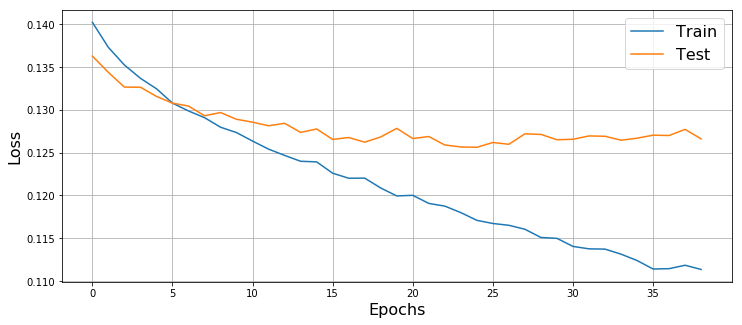

In [88]:
train(pretrained_model, 40, 0.001, train_loader, valid_loader)

## Validate your model

In [89]:
predictions_validation = []
targets = []
for X, y in valid_loader:
    if use_cuda:
        X = Variable(X).cuda(3)
    else:
        X = Variable(X)
   
    prediction = pretrained_model(X)
    predictions_validation.append(prediction.data.cpu().numpy())
    targets.append(y.cpu().numpy())

predictions_validation = np.concatenate(predictions_validation)
targets = np.concatenate(targets)

/home/a.fedotova/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


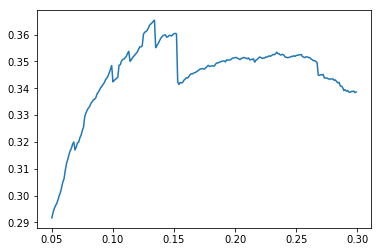

In [91]:
thr = np.arange(0.05, 0.3, 0.001)
f1 = np.zeros(len(thr))
for i, t in enumerate(thr):
    f1[i] = f1_score(targets, (predictions_validation > t).astype(int), average="macro")
    
plt.plot(thr, f1)

In [93]:
#find optimal threshold for probabilities
threshold = 0.13
print(f1_score(targets, (predictions_validation > threshold).astype(int), average="macro"))

0.36344547729


## Make submission

In [94]:
csv_sub = pd.read_csv("/mnt/disk/exch/human-protein-atlas-image-classification/sample_submission.csv")
csv_sub.columns = ["Id", "Target"]
csv_sub.to_csv("sample_submission_for_dataset.csv", index=False)

In [95]:
X_test = MultilabelDataset('sample_submission_for_dataset.csv','/mnt/disk/exch/human-protein-atlas-image-classification/test/','_green.png',
                                  data_transforms['val'], train=False
                                 )
X_test.mlb = X_train.mlb
test_loader = DataLoader(X_test,
                          batch_size=batch_size,
                          num_workers=4)

In [96]:
predictions = []
for X, _ in test_loader:
    if use_cuda:
        X = Variable(X).cuda(3)
    else:
        X = Variable(X)
    
    prediction = pretrained_model(X)
    predictions.append(prediction.data.cpu().numpy())

predictions_test = np.concatenate(predictions)

In [97]:
csv_sub = pd.read_csv("/mnt/disk/exch/human-protein-atlas-image-classification/sample_submission.csv")

In [98]:
csv_sub["Predicted"] = list(map(lambda t: " ".join([str(x) for x in t]), [list(map(int, t)) for t in X_train.mlb.inverse_transform((predictions_test > threshold))]))

In [99]:
csv_sub.to_csv("submit.csv", index=False)

Пробовала сеть с одним скрытым слоем и сигмоидами, потом число слоёв постепенно увеличивала. Пробовала добавить Dropout, но результат стал только хуже (возможно, стоило поперебирать разные значения вероятности). Добавила батч-нормализацию - потери на тесте стали меньше.